# Scaling the 2d Acoustic Wave Equation

## Unscaled version

2d Acoustic Wave Equation: $\frac{\partial^2 P}{\partial t^2} = c^2 \nabla^2 P + s(x, z, t)$

Where $ P \equiv P(x, z, t) $ and $ s(x, z, t) $ is a source term

$ \triangle t$ is calculated using the 2d CFL condition as follows: $ \triangle t = \frac{\triangle x}{\sqrt2  V_{max}}$

In [87]:
# import dependencies 
import devito as dv
import numpy as np
from examples.seismic.source import TimeAxis
from examples.seismic import RickerSource

# Initial grid: 2km x 2km, with spacing 100m
extent = (2000., 2000.)
shape = (200, 200)
x = dv.SpaceDimension(name='x', spacing=dv.Constant(name='h_x', value=extent[0]/(shape[0]-1)))
z = dv.SpaceDimension(name='z', spacing=dv.Constant(name='h_z', value=extent[1]/(shape[1]-1)))
grid = dv.Grid(extent=extent, shape=shape, dimensions=(x, z))

# setting up velocity field with a layered model
constant_vp = 3
vp = dv.Function(name='vp', grid=grid)
vp.data[:, :100] = 2.5  # layer 1: 2.5km/s
vp.data[:, 100:] = 3.5  # layer 2: 3.5km/s

# calculating timestep with 2d CFL condition, max V_p being the max given above, and dx=100
# played around with tn to get different output images - wave hits the edge of the grid around tn=400
t0, tn = 0., 250.
# commented out, this extracts max from spatially varying field
#c = float(vp.data.max())
c = constant_vp
dt = 0.1/(np.sqrt(2)*c)
time_range = TimeAxis(start=t0, stop=tn, step=dt)

# creating source term, f=0.03 kHz (30Hz)
src = RickerSource(name='src', grid=grid, f0=0.03, npoint=1, time_range=time_range)
# setting source to the middle of the grid
src.coordinates.data[:] = [1000., 1000.]

# creating pressure field
# increase space order to reduce the numerical dispersion artefact in output
p = dv.TimeFunction(name='p', grid=grid, space_order=4, time_order=2)

# injecting the source term to the pressure field, edit expr to vary source term
src_p = src.inject(field=p.forward, expr=src)

# defining pde and creating stencil
pde = p.dt2 - constant_vp**2*p.laplace
stencil = dv.Eq(p.forward, dv.solve(pde, p.forward))

# set up operator
op = dv.Operator([stencil] + src_p)

# call operator to propagate source
op(time=src.time_range.num-1, dt=dt)

Operator `Kernel` ran in 0.74 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.7353430000000528, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.00024899999999999955, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

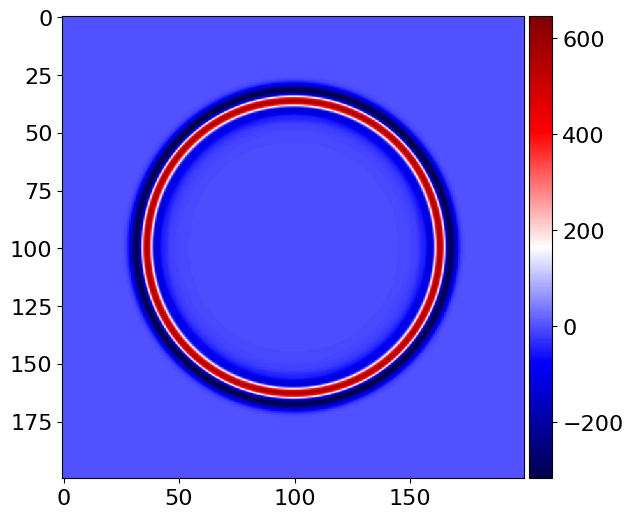

In [88]:
# visualise output
from examples.seismic import plot_image

plot_image(p.data[0], cmap='seismic')

## Scaling

### First attempt

Transformed 2d acoustic wave equation: $\frac{\partial^2 P'}{\partial t^2} = c^2 \nabla^2 P' + \frac{s(x, z, t)}{\alpha}$

Where $ P'(x, z, t) \equiv \frac{P(x, z, t)}{\alpha} $ where $ \alpha $ is a scaling factor that reduces the source term injection between -1 and 1. To reduce the source term to the desired size, $ \alpha $ is defined as the maximum amplitude of the source term increased by 5% (this increase was chosen arbitrarily). The steps of the transformation are as follows.

Re-arranging $ P'(x, z, t) \equiv \frac{P(x, z, t)}{\alpha} $ for $ P(x, z, t) $ and substituting into the 2d acoustic wave equation yields:

$ \alpha \frac{\partial^2 P'}{\partial t^2} = \alpha c^2 \nabla^2 P' + \alpha s(x, z, t)$

Dividing through by $ \alpha $ leads to our transformed equation:
$\frac{\partial^2 P'}{\partial t^2} = c^2 \nabla^2 P' + \frac{s(x, z, t)}{\alpha}$


In [89]:
# using same grid, time range, source set up and velocity as above

# redefine pressure field, pde and stencil, source term injection, set up new operator

# scaled pressure field
# increase space order to reduce the numerical dispersion artefact in output
p_scaled = dv.TimeFunction(name='ps', grid=grid, space_order=4, time_order=2)

# defining scaling factors
# maximum pressure of simulation is 1 (corresponds with source term)
# finding max amplitude of the source term
# this can form the basis of a scaling factor (i.e. scaling the source injection to be less than 1)
src_data = src.data
max_src = round(float(src_data.max()), 3)
alpha = 1.05*max_src

# redefining pde and stencil
pde_transform = p_scaled.dt2 - constant_vp**2*p_scaled.laplace
stencil_transform = dv.Eq(p_scaled.forward, dv.solve(pde_transform, p_scaled.forward))

# redefining source term injection
src_scaled = src.inject(field=p_scaled.forward, expr=src/alpha)

# new operator
op_scaled = dv.Operator([stencil_transform] + src_scaled)

# calling operator
op_scaled(time=src.time_range.num-1, dt=dt)

# rescaling output
p_scaled.data[:] *= alpha

Operator `Kernel` ran in 0.78 s


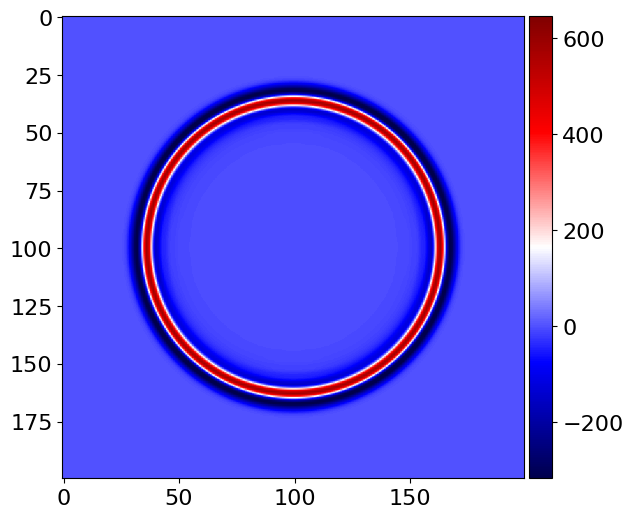

In [90]:
# showing output
plot_image(p_scaled.data[0], cmap='seismic')

### Second attempt

The scaling procedure above produces similar results as the unscaled version (same order of magnitude and values, decimal digits vary). However, this doesn't take into account the value of $ \triangle t ^2 c^2 $ which can be equal to ~0.004 or $ \triangle t ^2$ which can be equal to ~0.0004. These values could lead to an underflow, so should be scaled to around unity to avoid this. 

Following the procedure from the Oullet 2020 'Seismic modeling and inversion using half-precision floating-point numbers' paper, we can define two scaling factors $e_c$ and $e_t$ to bring $ \triangle t ^2 c^2$ and $ \triangle t^2$ to unity. These are defined as follows:

$e_c = -\log_2{(\triangle t^2 c^2)} $

$e_t = -\log_2{(\triangle t^2)}$

We then package these logarithmic scaling factors into two variables $a$ and $b$ to fit in our stencil:

$ a = 2^{e_c} \triangle t^2 c^2 $ 

$ b = 2^{e_t} \triangle t^2$

Our unscaled stencil for the 2d acoustic wave equation is given by:

$P^{n+1}_{i, j} = 2P^{n}_{i, j} - P^{n-1}_{i, j} + c^2\triangle t^2 \nabla^2 P + \triangle ^2 S(x, z, t)$

Inserting our variables $a$ and $b$ into the above stencil gives a transformed stencil for $P'^{n+1}_{i, j}$:

$P'^{n+1}_{i, j} = 2P'^{n}_{i, j} - P'^{n-1}_{i, j} + a \nabla^2 P' + b S'(x, z, t)$

This will then be rescaled after the computation to arrive at the true value of $P$

By the linearity of the wave equation, $ P' = 2^{e_c} P \implies P = 2^{-e_c}P'$

Operator `Kernel` ran in 0.70 s


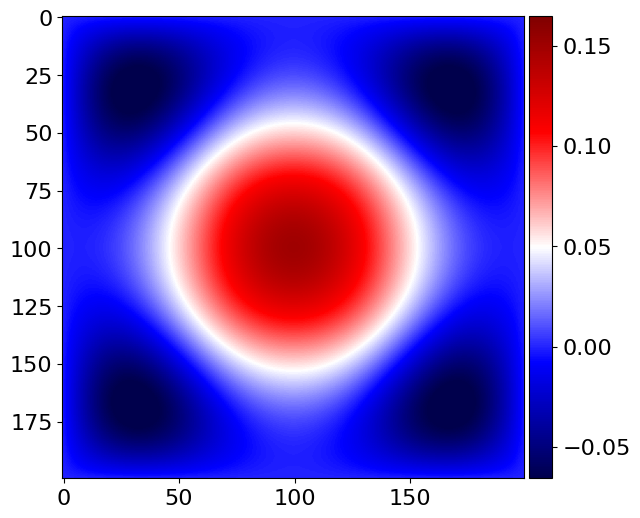

In [91]:
# new pressure field
p_new = dv.TimeFunction(name='P', grid=grid, space_order=4, time_order=2)

# defining scale factor
ec = -np.log2(dt**2*c**2)
a = 2**ec*dt**2*c**2

# new stencil with scaling factor attached to laplacian term
new_stencil = dv.Eq(p_new.forward, (2*p_new - p_new.backward + a*p_new.laplace))

# injecting the source term to the new pressure field
src_n = src.inject(field=p_new.forward, expr=src)

# new operator 
new_op = dv.Operator([new_stencil] + src_n)

# call operator 
new_op(time=src.time_range.num-1, dt=dt)

# rescale output
p_new.data[:] /= 2**ec

# show output 
plot_image(p_new.data[0], cmap='seismic')

## Verifying that scaling-rescaling produces same result as unscaled

Single precision generally allows around 7 decimal places, while half precision allows around 3/3.5. As a result of this, the relative/absolute tolerances are set at 3/4 decimal places in an attempt to account for differences that may be encountered when rounding from single to half precision.

In [5]:
# compare the output of the two simulations 
close_check = np.isclose(p.data, p_scaled.data, rtol=1e-3, atol=1e-4)

# check if all values are close
# if they are the same, should return Data(True)
all_close = np.all(close_check)
all_close

Data(False)